# Pick 1% diverse subset of ChEMBL

The notebook evaluates methods for selecting chemically diverse subsets from the ChEMBL database. It compares the performance of `OnlineDiversityPicker` from `moll`, with GPU acceleration, against `MaxMinPicker` from RDKit, and a control method of random selection. Diversity is assessed using Tanimoto coefficients as the chemical similarity metric. The accelerated `OnlineDiversityPicker` demonstrates improved results over `MaxMinPicker` in terms of diversity and speed.

RDKit is used to calculate Morgan fingerprints for each molecule in the dataset. The fingerprints are used to calculate Tanimoto coefficients, which are used as the similarity metric for diversity selection.

The `OnlineDiversityPicker` algorithm enhances efficiency by calculating molecular repulsion within a limited local vicinity, denoted by `k_neighbors`. In this demonstration, `k_neighbors` is set to **1000** to showcase the algorithm's capability to curate quality molecular subsets. However, for routine applications, a smaller neighborhood size—typically around `k_neighbors` of **100** — is sufficient to achieve satisfactory results. The `OnlineDiversityPicker` exhibits linear scalability, making it applicable for both small and large datasets. It operates with or without the use of GPU acceleration.

In [1]:
import os

import datamol as dm
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from moll.metrics import one_minus_tanimoto
from moll.pick import OnlineDiversityPicker
from moll.small import Molecule
from moll.utils import iter_slices, map_concurrently, no_warnings, unpack_arguments

In [2]:
DATA_FILE = "/data/datasets/chembl/chembl_33_chemreps.txt.gz"
N_WORKERS = os.cpu_count()

FINGERPRINT_SIZE = 1000
FINGERPRINT_RADIUS = 2

FRACTION_TO_PICK = 1 / 100  # 1%
N_BATCHES = 200

GPU is used to accelerate calculations

In [3]:
!nvidia-smi --query-gpu=name,memory.total --format=csv,noheader

NVIDIA GeForce RTX 4090, 24564 MiB


CPU model:

In [4]:
!lscpu | grep 'Model name'

Model name:                         12th Gen Intel(R) Core(TM) i9-12900K


In [5]:
N_WORKERS

24

## Load ChEMBL

In [6]:
df_chembl = pd.read_csv(DATA_FILE, sep="\t")
df_chembl

,chembl_id,canonical_smiles,standard_inchi,standard_inchi_key
0,CHEMBL153534,Cc1cc(-c2csc(N=C(N)N)n2)cn1C,InChI=1S/C10H13N5S/c1-6-3-7(4-15(6)2)8-5-16-10...,MFRNFCWYPYSFQQ-UHFFFAOYSA-N
1,CHEMBL440060,CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H...,InChI=1S/C123H212N44O34S/c1-19-63(12)96(164-11...,RSEQNZQKBMRQNM-VRGFNVLHSA-N
2,CHEMBL440245,CCCC[C@@H]1NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(...,InChI=1S/C160H268N50O41/c1-23-27-41-95-134(228...,FTKBTEIKPOYCEX-OZSLQWTKSA-N
3,CHEMBL440249,CC(C)C[C@@H]1NC(=O)CNC(=O)[C@H](c2ccc(O)cc2)NC...,InChI=1S/C124H154ClN21O39/c1-57(2)48-81-112(17...,UYSXXKGACMHPIM-KFGDMSGDSA-N
4,CHEMBL405398,Brc1cccc(Nc2ncnc3ccncc23)c1NCCN1CCOCC1,InChI=1S/C19H21BrN6O/c20-15-2-1-3-17(18(15)22-...,VDSXZXJEWIWBCG-UHFFFAOYSA-N
...,...,...,...,...
2372669,CHEMBL4298696,CCCCCCCCCCCCCCCCCCPCCCCCCCCCCCCCC.F[PH](F)(F)(...,InChI=1S/C32H67P.F6HP/c1-3-5-7-9-11-13-15-17-1...,ZAKUDCIPPLAGQL-UHFFFAOYSA-N
2372670,CHEMBL4298698,C[n+]1cn([C@@H]2O[C@H](CO[P@@](=O)(S)OP(=O)([O...,InChI=1S/C11H18N5O13P3S/c1-15-3-16(8-5(15)9(19...,OTIKKVINVWNBOQ-LDJOHHLFSA-N
2372671,CHEMBL4298702,c1ccc(C2CC(C3CC(c4ccccc4)OC(c4ccccc4)C3)CC(c3c...,InChI=1S/C34H34O2/c1-5-13-25(14-6-1)31-21-29(2...,NZIGZXNUFVMHNV-UHFFFAOYSA-N
2372672,CHEMBL4298703,CSCC[C@H](NC=O)C(=O)N[C@@H](CCCNC(=N)NS(=O)(=O...,InChI=1S/C78H107N18O21PS2/c1-43-44(2)65(45(3)5...,IIHLOGWTFCCTPB-WTIPWMETSA-N


In [7]:
BATCH_SIZE = int(len(df_chembl) / N_BATCHES)

In [8]:
N_MOL_TO_PICK = int(len(df_chembl) * FRACTION_TO_PICK)
N_MOL_TO_PICK

23726

Shuffle the data just in case

In [9]:
df_chembl = df_chembl.sample(frac=1, random_state=42)
smiles = df_chembl.canonical_smiles

## `OnlineDiversityPicker` from `moll`

Define a function to prepare the data (fingerprints and compound labels) for the `OnlineDiversityPicker` algorithm:

In [10]:
@no_warnings
@unpack_arguments
def gen_fp_and_label(index, smiles):
    mol = Molecule.from_smiles(smiles, index)
    fp = mol.to_fp("morgan", size=FINGERPRINT_SIZE, radius=FINGERPRINT_RADIUS)
    return fp, mol.label

Next cell uses built-in data utils to parallelly prepare fingerprints and labels of the molecules. Time of execution is measured.

In [11]:
%%time

# Init moll's picker
picker = OnlineDiversityPicker(
    capacity=N_MOL_TO_PICK,
    k_neighbors=1000,  # you can use much smaller number here, it's a demo
    similarity_fn="one_minus_tanimoto",
    threshold=0.7,
)

# Create a generator of fingerprints
result_generator = map_concurrently(
    gen_fp_and_label,
    smiles.items(),  # iter over (index, smiles) pairs
    n_workers=N_WORKERS,  # this can be done automatically
    proc=True,  # enable multiprocessing, not multithreading,
    exception_fn=None,  # return `None` for molecules that failed to be processed
)

# Split generator into batches
batches = iter_slices(
    result_generator,
    slice_size=BATCH_SIZE,
    filter_fn=lambda x: x is not None,  # `None` values are removed from the batch
    transform_fn="transpose",  # transpose batch to (fps, labels) format
)

# Iterate over batches
for fps, labels in tqdm(batches, total=N_BATCHES):
    picker.update(fps, labels)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 7min 40s, sys: 31.2 s, total: 8min 11s
Wall time: 6min 58s


Note the execution time. The diverse subset has been selected.

In [12]:
df_picked = df_chembl.loc[picker.labels]
df_picked

,chembl_id,canonical_smiles,standard_inchi,standard_inchi_key
1612229,CHEMBL1992147,COc1ccc(-c2c(C)c(C(=O)O)nc(-c3ccc4c(O)c(OC)c5c...,InChI=1S/C28H27N5O7/c1-11-16(12-8-10-15(38-4)2...,SQQXRXKYTKFFSM-UHFFFAOYSA-N
183825,CHEMBL195113,CC[C@]1(C)OC2(OCC(CO)O2)C(OC(C)C)=C1c1ccc(S(C)...,InChI=1S/C20H28O7S/c1-6-19(4)17(14-7-9-16(10-8...,SPYVFEBIRQIAQN-YHDJDMAPSA-N
2362303,CHEMBL4291460,COc1nc(OC(=O)C(N)C(C)C)nc(Oc2c(OC)cc(Cc3cnc(N)...,InChI=1S/C22H28N8O6/c1-10(2)15(23)18(31)36-22-...,DDPGYMCYDSBGJA-UHFFFAOYSA-N
242223,CHEMBL243399,CC(=O)Nc1ccc(-c2n[nH]c3c2Cc2cc(CN[C@H]4CC[C@H]...,InChI=1S/C26H30N4O/c1-16-3-8-21(9-4-16)27-15-1...,VHFOPTWBFCFHMH-OQIWPSSASA-N
1095408,CHEMBL4971950,O=S(=O)(Cc1ccon1)N(C[C@H]1CCOC1)C1CC1,"InChI=1S/C12H18N2O4S/c15-19(16,9-11-4-6-18-13-...",FBRDCPWIHKSWDF-SNVBAGLBSA-N
...,...,...,...,...
1829039,CHEMBL3115080,CCCCc1ccc(N(C(=O)c2ccccc2Cl)C(C(=O)NC(C)(C)C)c...,InChI=1S/C35H37ClN2O5/c1-5-6-12-24-17-19-26(20...,KWSCKMBQSBXXEI-UHFFFAOYSA-N
438981,CHEMBL440150,Oc1c(-c2ccsc2)cnc2c(-c3cccc(Br)c3)cnn12,InChI=1S/C16H10BrN3OS/c17-12-3-1-2-10(6-12)13-...,AMDJHJJNKSGMBL-UHFFFAOYSA-N
445356,CHEMBL4522233,O=C(N[C@@H]1COCC[C@H]1O)C1(CO)CC1,InChI=1S/C10H17NO4/c12-6-10(2-3-10)9(14)11-7-5...,POVKPBKDHDZPJI-HTQZYQBOSA-N
374444,CHEMBL370476,NCC1OC(n2c3cc(F)c(F)cc3c3c4c(c5c6cc(F)c(F)cc6[...,InChI=1S/C26H16F6N4O5/c27-8-1-6-12(3-10(8)29)3...,AOMCGGJSCBYDCG-UHFFFAOYSA-N


Visualize some of the picked molecules.

In [13]:
picked_examples = [
    Molecule.from_smiles(smi).rdkit
    for smi in df_picked.sample(15, random_state=42).canonical_smiles
]

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


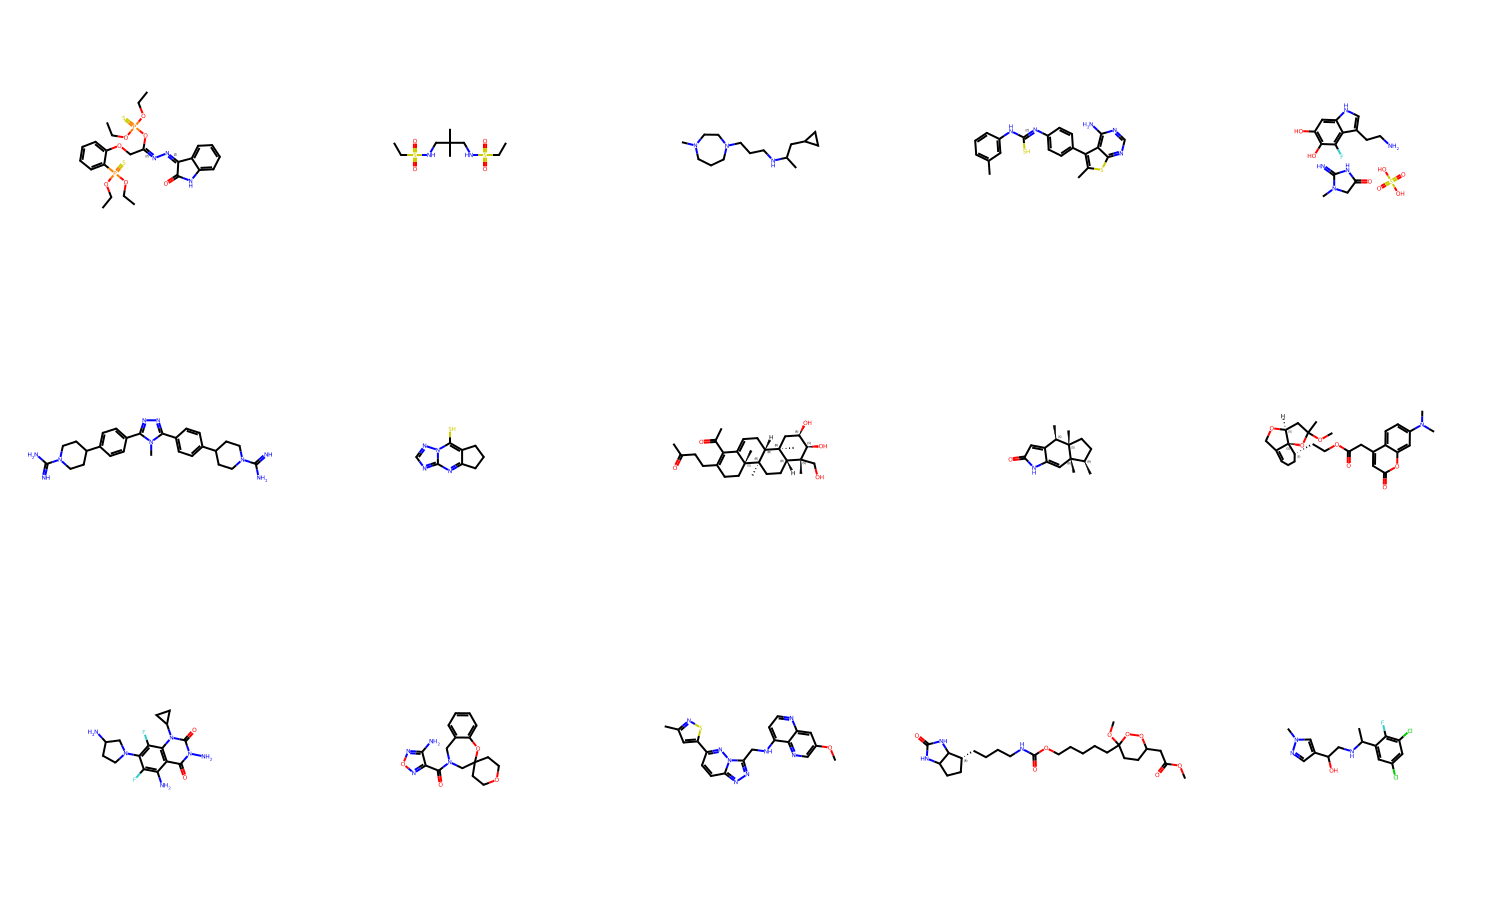

In [14]:
dm.to_image(picked_examples, n_cols=5)

## `MaxMinPicker` from RDKit

Now, RDKit's `MaxMinPicker` is used to do the same thing. The same data is used, and the same number of molecules will be picked.

In [15]:
from rdkit.Chem import AllChem as Chem
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

Function to prepare the data for `MaxMinPicker`:

In [16]:
@no_warnings
def smi_to_fp(smi) -> np.ndarray | None:
    mol = Chem.MolFromSmiles(smi)
    fp = Chem.GetMorganFingerprintAsBitVect(
        mol,
        FINGERPRINT_RADIUS,
        FINGERPRINT_SIZE,
    )
    return fp

Time of the picking is measured.

In [17]:
%%time

# Fingerprints generator
fps = map_concurrently(
    smi_to_fp,
    smiles,
    proc=True,
    n_workers=N_WORKERS,
    exception_fn="ignore",
)

fps = list(fps)

# Init RDKit picker
picker_rdkit = MaxMinPicker()

# Pick molecules
picked_idxs_rdkit = picker_rdkit.LazyBitVectorPick(
    fps,
    len(fps),
    N_MOL_TO_PICK,
    seed=42,
)

CPU times: user 12min 19s, sys: 29.3 s, total: 12min 48s
Wall time: 12min 25s


## Compare similarity distributions

Compute Tanimoto distances within the subsets of compounds picked by different methods.

In [18]:
def dists(fps):
    """
    Compute shifted Tanimoto distances between fingerprints.
    """
    return jax.vmap(one_minus_tanimoto)(fps[:-1], fps[1:])

### `moll`

In [19]:
picked_moll = jnp.array(picker.points)
dists_moll = dists(picked_moll)

### RDKit

In [20]:
picked_rdkit = jnp.array([fps[i] for i in picked_idxs_rdkit])
dists_rdkit = dists(picked_rdkit)

### Random subset

As a control, a random subset of the same size is picked.

In [21]:
key = jax.random.PRNGKey(42)
picked_idxs_random = jax.random.choice(
    key, len(fps), shape=(N_MOL_TO_PICK,), replace=False
)
picked_random = jnp.array([fps[i] for i in picked_idxs_random])
dists_random = dists(picked_random)

### Distribution of Tanimoto distances

The distributions of Tanimoto distances (one minus Tanimoto similarity) within the picked subsets are shown below.

/home/sheg/moll/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sheg/moll/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sheg/moll/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


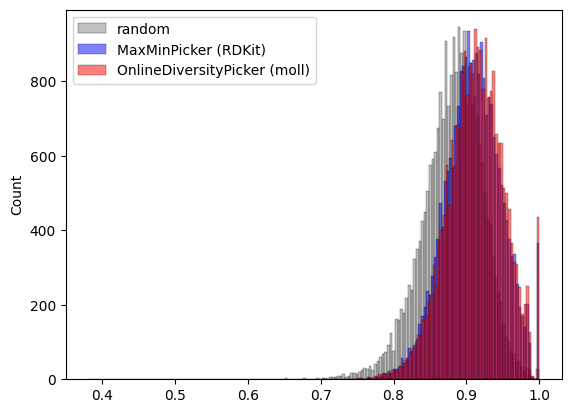

In [22]:
sns.histplot(dists_random, label="random", alpha=0.5, color="gray")
sns.histplot(dists_rdkit, label="MaxMinPicker (RDKit)", alpha=0.5, color="blue")
sns.histplot(dists_moll, label="OnlineDiversityPicker (moll)", alpha=0.5, color="red")
plt.legend()
plt.show()

Compute average Tanimoto distance within each subset.

In [23]:
results = {
    "random": dists_random,
    "rdkit": dists_rdkit,
    "moll": dists_moll,
}

for name, tanimoto in results.items():
    print(f"{tanimoto.mean().item():.3f} for {name}")

0.881 for random
0.909 for rdkit
0.913 for moll


## Conclusion

- `OnlineDiversityPicker` is faster (see **wall time** under the cells with calculations) than `MaxMinPicker` and works online: fingerprints are calculated on the fly on the CPU and the diversity is calculated on the GPU in parallel.
- `OnlineDiversityPicker` is better than a random pick.
- `OnlineDiversityPicker` is comparable (even better in this specific case) to `MaxMinPicker` in terms of diversity.
- Adjusting the `k_neighbors` parameter influences the diversity of the resulting subset, with larger values tending to yield more diversity. However, this increment also affects the speed.